In [19]:
import os
os.chdir("/Users/jam/msc/course-works")
print(os.getcwd())  # Verify the change

/Users/jam/msc/course-works


In [21]:
import pandas as pd
df = pd.read_csv("online_retail.csv")
df.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [32]:
df.dtypes

index            int64
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

Data Cleaning

In [24]:
# Check for missing values in each column
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Description      1454
CustomerID     135080
dtype: int64

In [ ]:
# 24% of CustomerID records could be due to guest checkout, better to check for cancel or negative transactions

In [26]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

Number of duplicate rows: 0


In [28]:
# Check for negative values in Quantity and UnitPrice
print(df[df["Quantity"] <= 0].shape[0], "rows with negative Quantity")
print(df[df["UnitPrice"] <= 0].shape[0], "rows with zero/negative UnitPrice")

10624 rows with negative Quantity
2517 rows with zero/negative UnitPrice


In [36]:
df[df["Quantity"] < 0]["Description"].value_counts().head(20)

Description
Manual                                244
REGENCY CAKESTAND 3 TIER              181
POSTAGE                               126
check                                 120
JAM MAKING SET WITH JARS               87
Discount                               77
SET OF 3 CAKE TINS PANTRY DESIGN       74
SAMPLES                                61
STRAWBERRY CERAMIC TRINKET BOX         55
ROSES REGENCY TEACUP AND SAUCER        54
RECIPE BOX PANTRY YELLOW DESIGN        47
damages                                45
WOOD 2 DRAWER CABINET WHITE FINISH     45
LUNCH BAG RED RETROSPOT                44
JUMBO BAG RED RETROSPOT                44
WHITE HANGING HEART T-LIGHT HOLDER     42
damaged                                42
GREEN REGENCY TEACUP AND SAUCER        42
RED RETROSPOT CAKE STAND               42
?                                      41
Name: count, dtype: int64

In [38]:
df[df["UnitPrice"] == 0]["Description"].value_counts().head(20)

Description
check                              159
?                                   47
damages                             45
damaged                             43
found                               25
sold as set on dotcom               20
adjustment                          16
Damaged                             14
Unsaleable, destroyed.               9
thrown away                          9
FRENCH BLUE METAL DOOR SIGN 1        9
amazon                               8
FRENCH BLUE METAL DOOR SIGN 8        8
Found                                8
FRENCH BLUE METAL DOOR SIGN 4        7
RECIPE BOX PANTRY YELLOW DESIGN      7
Amazon                               7
FRENCH BLUE METAL DOOR SIGN No       7
??                                   7
OWL DOORSTOP                         7
Name: count, dtype: int64

In order to do a market basket analysis we need only below fields.
InvoiceNo (Transaction ID)
StockCode (Product ID)
Description (Optional for interpretation)
Quantity (To determine frequent items)

In [41]:
df_mba = df[["InvoiceNo", "StockCode", "Quantity", "Description"]]

In [45]:
df_mba.head()

,InvoiceNo,StockCode,Quantity,Description
0,536365,85123A,6,WHITE HANGING HEART T-LIGHT HOLDER
1,536365,71053,6,WHITE METAL LANTERN
2,536365,84406B,8,CREAM CUPID HEARTS COAT HANGER
3,536365,84029G,6,KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,84029E,6,RED WOOLLY HOTTIE WHITE HEART.


In [49]:
df_mba[df_mba["Quantity"] < 0]["Description"].value_counts().head(20)

Description
Manual                                244
REGENCY CAKESTAND 3 TIER              181
POSTAGE                               126
check                                 120
JAM MAKING SET WITH JARS               87
Discount                               77
SET OF 3 CAKE TINS PANTRY DESIGN       74
SAMPLES                                61
STRAWBERRY CERAMIC TRINKET BOX         55
ROSES REGENCY TEACUP AND SAUCER        54
RECIPE BOX PANTRY YELLOW DESIGN        47
damages                                45
WOOD 2 DRAWER CABINET WHITE FINISH     45
LUNCH BAG RED RETROSPOT                44
JUMBO BAG RED RETROSPOT                44
WHITE HANGING HEART T-LIGHT HOLDER     42
damaged                                42
GREEN REGENCY TEACUP AND SAUCER        42
RED RETROSPOT CAKE STAND               42
?                                      41
Name: count, dtype: int64

In [51]:
print(df_mba[df_mba["Quantity"] <= 0].shape[0], "rows with negative Quantity")

10624 rows with negative Quantity


In [57]:
df_mba.size

2167636

Since negative quantities likely indicate returns or cancellations

In [60]:
df_mba = df_mba[df_mba["Quantity"] > 0]

In [62]:
df_mba.size

2125140

In [72]:
# Check for '??' values
df[df["Description"] == "??"].shape[0]

7

In [74]:
# Check for empty or null values
df["Description"].isnull().sum()

1454

In [64]:
#Most Sold Products

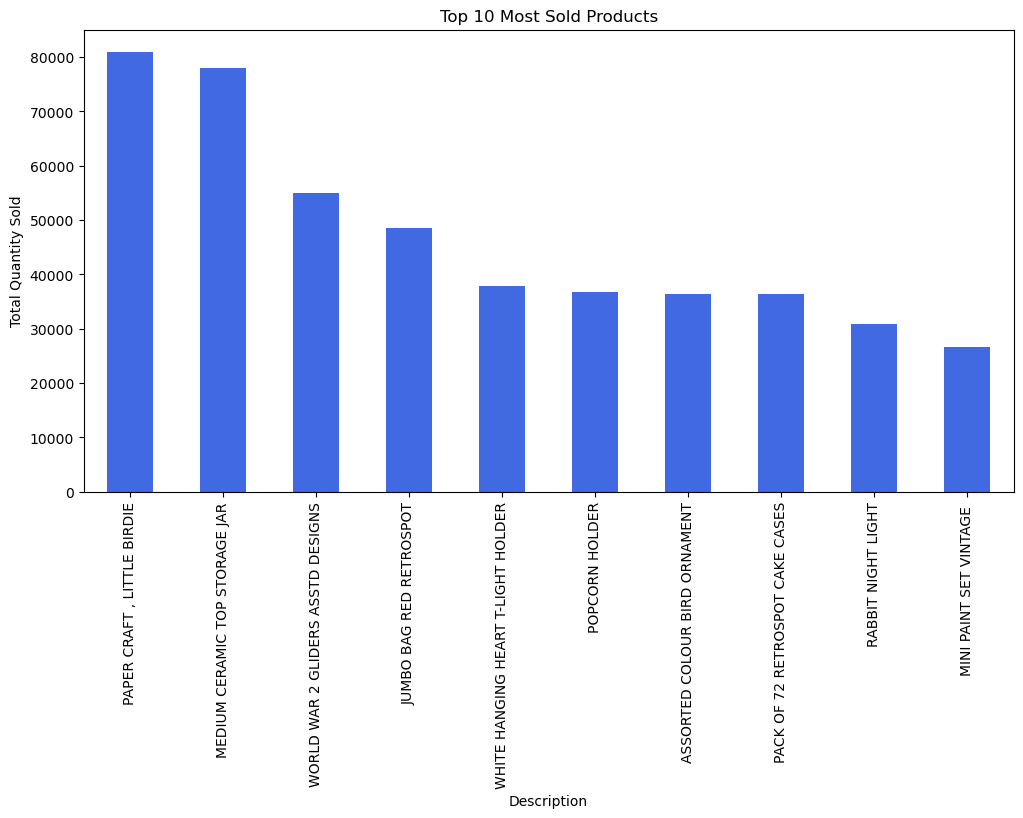

In [68]:
import matplotlib.pyplot as plt

top_products = df_mba.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
top_products.plot(kind="bar", color="royalblue")
plt.xlabel("Description")
plt.ylabel("Total Quantity Sold")
plt.title("Top 10 Most Sold Products")
plt.show()


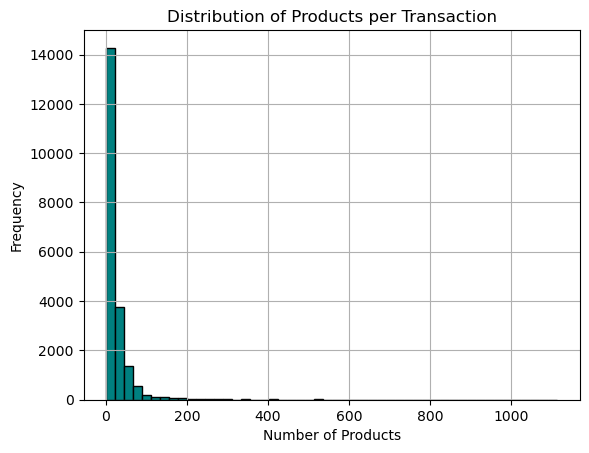

In [76]:
df_mba.groupby("InvoiceNo")["StockCode"].count().hist(bins=50, color="teal", edgecolor="black")
plt.xlabel("Number of Products")
plt.ylabel("Frequency")
plt.title("Distribution of Products per Transaction")
plt.show()

In [ ]:
import seaborn as sns

# Create a co-occurrence matrix of items frequently bought together
basket_matrix = df_mba.pivot_table(index="InvoiceNo", columns="StockCode", values="Quantity", aggfunc="sum").fillna(0)
basket_matrix[basket_matrix > 0] = 1  # Convert to 1 if purchased, else 0

# Compute correlation between items
corr_matrix = basket_matrix.corr(method="pearson")

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Product Co-occurrence Heatmap")
plt.show()


In [ ]:
import networkx as nx

# Select strong association rules (lift > 1.5)
rules_filtered = rules[rules["lift"] > 1.5]

# Create a network graph
G = nx.from_pandas_edgelist(rules_filtered, source="antecedents", target="consequents", edge_attr="lift")

plt.figure(figsize=(10, 6))
nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray", node_size=3000, font_size=10)
plt.title("Product Association Network")
plt.show()
